# Transfer Risk Classification & Model Interpretability (SHAP)

**DAMA Hackathon 2026**  
Task 1: Classify player transfer risk level (Low / Medium / High)  
Task 2: Explain both models using SHAP values for global + local interpretability


In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix,
                              ConfusionMatrixDisplay, roc_auc_score)
from sklearn.model_selection import cross_val_score, StratifiedKFold
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

sns.set_theme(style='whitegrid', font_scale=1.1)
plt.rcParams['figure.dpi'] = 120
RANDOM_STATE = 42
CLASSES = ['Low', 'Medium', 'High']

with open('../outputs/processed_data.pkl', 'rb') as f:
    d = pickle.load(f)

X_train, X_val, X_test           = d['X_train'],    d['X_val'],    d['X_test']
X_train_sc, X_val_sc, X_test_sc  = d['X_train_sc'], d['X_val_sc'], d['X_test_sc']
y_train = d['y_cls_tr']    # 0=Low, 1=Medium, 2=High
y_val   = d['y_cls_val']
y_test  = d['y_cls_te']
feature_cols = d['feature_cols']

print('Data loaded OK')
print('Class distribution (train):', pd.Series(y_train).value_counts().sort_index().to_dict())

Data loaded OK
Class distribution (train): {0: 875, 1: 694, 2: 391}


## 1. Classification Models

In [2]:
def evaluate_classifier(name, model, X_tr, y_tr, X_te, y_te, use_scaled=False):
    model.fit(X_tr, y_tr)
    preds = model.predict(X_te)
    proba = model.predict_proba(X_te)
    acc = (preds == y_te).mean()
    try:
        auc = roc_auc_score(y_te, proba, multi_class='ovr', average='macro')
    except Exception:
        auc = float('nan')
    report = classification_report(y_te, preds, target_names=CLASSES, output_dict=True)
    macro_f1 = report['macro avg']['f1-score']
    print(f'\n=== {name} ===')
    print(classification_report(y_te, preds, target_names=CLASSES))
    return {'Model': name, 'Accuracy': acc, 'Macro F1': macro_f1, 'ROC-AUC (OvR)': auc,
            'preds': preds, 'proba': proba, 'model_obj': model}

cls_results = []

In [3]:
# Logistic Regression (baseline)
lr = LogisticRegression(max_iter=2000, C=1.0, solver='lbfgs',
                         random_state=RANDOM_STATE)
cls_results.append(evaluate_classifier('Logistic Regression', lr, X_train_sc, y_train, X_test_sc, y_test))


=== Logistic Regression ===
              precision    recall  f1-score   support

         Low       0.48      0.83      0.61       188
      Medium       0.37      0.23      0.28       148
        High       0.00      0.00      0.00        84

    accuracy                           0.45       420
   macro avg       0.28      0.35      0.30       420
weighted avg       0.34      0.45      0.37       420



In [4]:
# Random Forest
rfc = RandomForestClassifier(n_estimators=400, max_depth=None, min_samples_leaf=2,
                              max_features='sqrt', n_jobs=-1, random_state=RANDOM_STATE)
cls_results.append(evaluate_classifier('Random Forest', rfc, X_train, y_train, X_test, y_test))


=== Random Forest ===
              precision    recall  f1-score   support

         Low       0.46      0.79      0.58       188
      Medium       0.41      0.26      0.32       148
        High       0.40      0.02      0.04        84

    accuracy                           0.45       420
   macro avg       0.42      0.36      0.32       420
weighted avg       0.43      0.45      0.38       420



In [5]:
# XGBoost
xgbc = XGBClassifier(n_estimators=500, learning_rate=0.05, max_depth=5, subsample=0.8,
                      colsample_bytree=0.8, eval_metric='mlogloss',
                      random_state=RANDOM_STATE, verbosity=0)
cls_results.append(evaluate_classifier('XGBoost', xgbc, X_train, y_train, X_test, y_test))


=== XGBoost ===
              precision    recall  f1-score   support

         Low       0.46      0.60      0.52       188
      Medium       0.38      0.36      0.37       148
        High       0.29      0.12      0.17        84

    accuracy                           0.42       420
   macro avg       0.38      0.36      0.35       420
weighted avg       0.40      0.42      0.40       420



In [6]:
# LightGBM
lgbmc = LGBMClassifier(n_estimators=500, learning_rate=0.05, max_depth=5, num_leaves=40,
                        subsample=0.8, colsample_bytree=0.8,
                        random_state=RANDOM_STATE, verbose=-1)
cls_results.append(evaluate_classifier('LightGBM', lgbmc, X_train, y_train, X_test, y_test))


=== LightGBM ===
              precision    recall  f1-score   support

         Low       0.46      0.55      0.50       188
      Medium       0.38      0.39      0.38       148
        High       0.35      0.19      0.25        84

    accuracy                           0.42       420
   macro avg       0.40      0.37      0.38       420
weighted avg       0.41      0.42      0.41       420



## 2. Classification Leaderboard

In [7]:
cls_lb = pd.DataFrame([{k: v for k, v in r.items() if k not in ('preds', 'proba', 'model_obj')}
                        for r in cls_results])
cls_lb = cls_lb.sort_values('Macro F1', ascending=False)
print(cls_lb.to_string(index=False))
cls_lb.to_csv('../outputs/classification_leaderboard.csv', index=False)

              Model  Accuracy  Macro F1  ROC-AUC (OvR)
           LightGBM  0.419048  0.376198       0.544093
            XGBoost  0.419048  0.353358       0.542103
      Random Forest  0.450000  0.316203       0.548493
Logistic Regression  0.452381  0.296782       0.521517


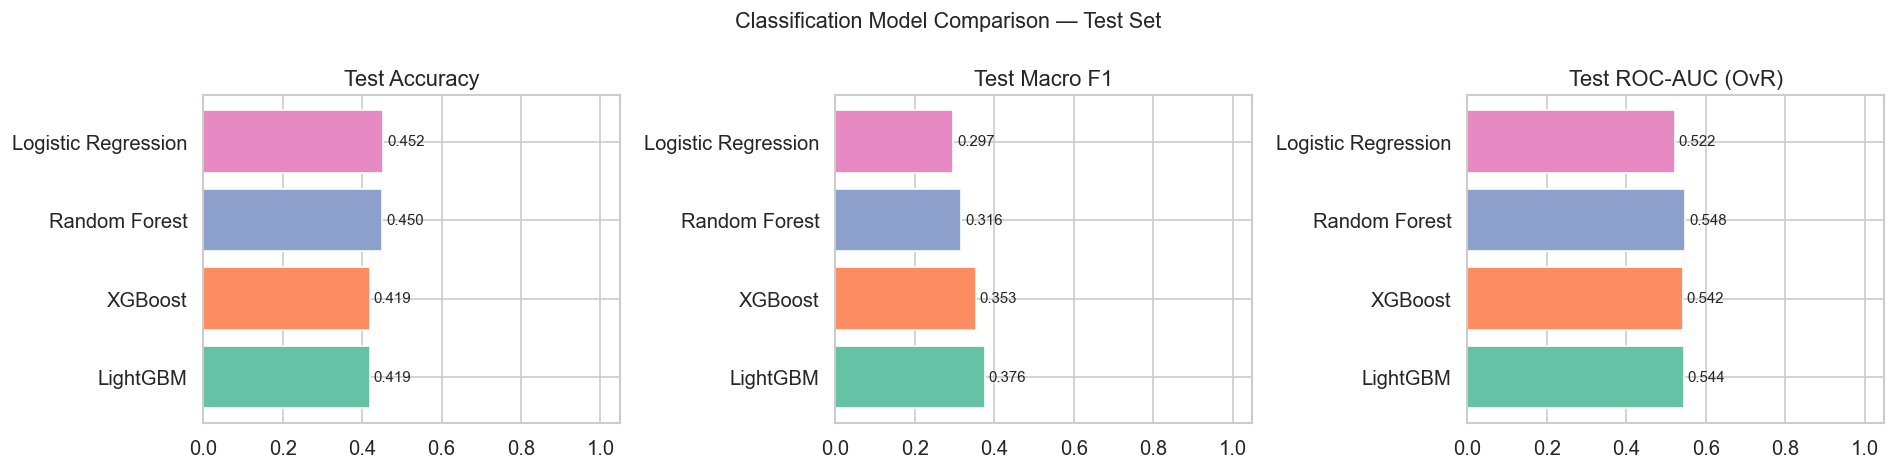

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
for ax, metric in zip(axes, ['Accuracy', 'Macro F1', 'ROC-AUC (OvR)']):
    colors = sns.color_palette('Set2', len(cls_lb))
    bars = ax.barh(cls_lb['Model'], cls_lb[metric], color=colors, edgecolor='white')
    ax.set_title(f'Test {metric}')
    ax.set_xlim(0, 1.05)
    for bar, val in zip(bars, cls_lb[metric]):
        ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2,
                f'{val:.3f}', va='center', fontsize=9)

plt.suptitle('Classification Model Comparison — Test Set', fontsize=13)
plt.tight_layout()
plt.savefig('../outputs/classification_comparison.png', bbox_inches='tight')
plt.show()

## 3. Confusion Matrix — Best Classifier

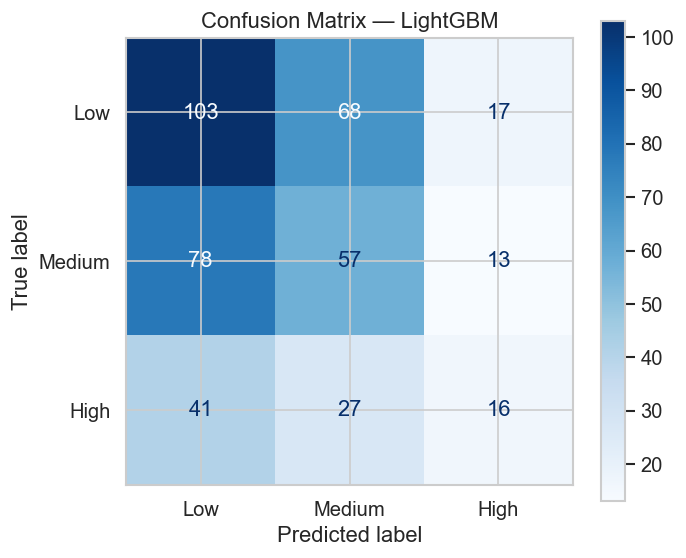

In [9]:
best_cls_name = cls_lb.iloc[0]['Model']
best_cls_res  = next(r for r in cls_results if r['Model'] == best_cls_name)
best_cls_model = best_cls_res['model_obj']

cm = confusion_matrix(y_test, best_cls_res['preds'])
fig, ax = plt.subplots(figsize=(6, 5))
disp = ConfusionMatrixDisplay(cm, display_labels=CLASSES)
disp.plot(ax=ax, colorbar=True, cmap='Blues', values_format='d')
ax.set_title(f'Confusion Matrix — {best_cls_name}')
plt.tight_layout()
plt.savefig('../outputs/classification_confusion_matrix.png', bbox_inches='tight')
plt.show()

## 4. SHAP — Regression Model Interpretability

In [10]:
with open('../outputs/best_regressor.pkl', 'rb') as f:
    reg_bundle = pickle.load(f)
reg_model  = reg_bundle['model']
reg_name   = reg_bundle['name']
print(f'Loaded best regressor: {reg_name}')

# TreeExplainer works for Random Forest, XGBoost, LightGBM, GradientBoosting
explainer_reg   = shap.TreeExplainer(reg_model)
shap_values_reg = explainer_reg(X_test)
print('TreeExplainer computed — shape:', shap_values_reg.values.shape)

Loaded best regressor: LightGBM
TreeExplainer computed — shape: (420, 44)


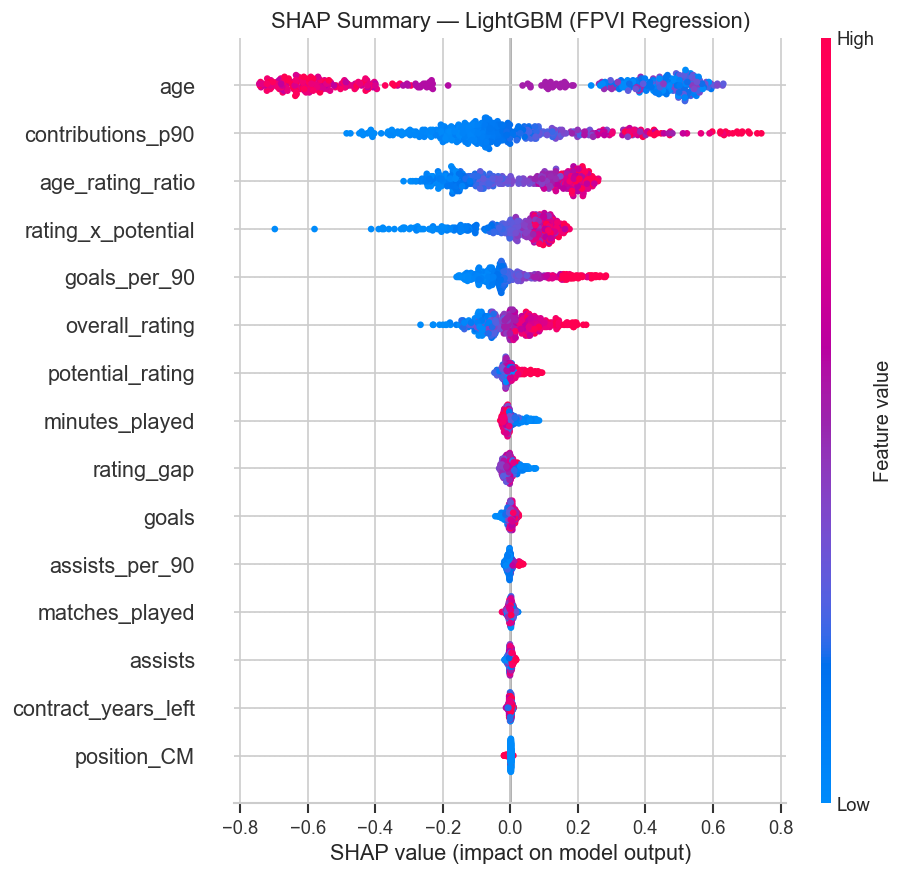

In [11]:
# Global: SHAP beeswarm (shows direction and magnitude)
shap.summary_plot(shap_values_reg, X_test, max_display=15, show=False)
plt.title(f'SHAP Summary — {reg_name} (FPVI Regression)')
plt.tight_layout()
plt.savefig('../outputs/shap_regression_summary.png', bbox_inches='tight')
plt.show()

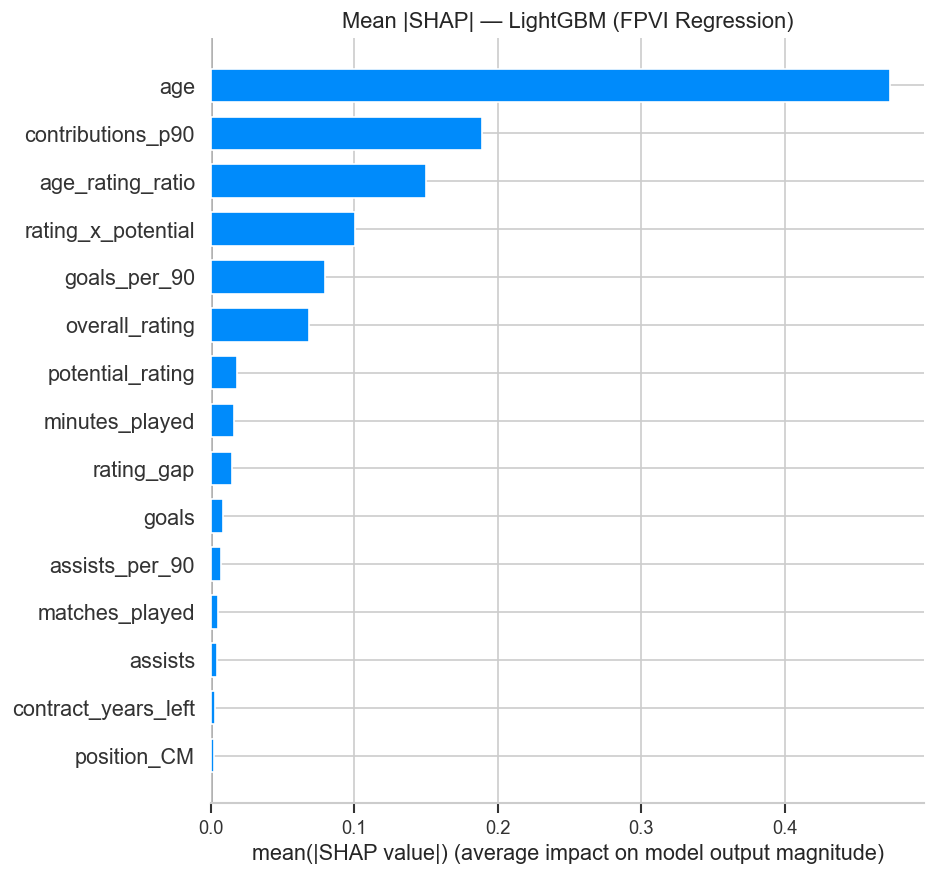

In [12]:
# Global: mean |SHAP| bar chart
shap.summary_plot(shap_values_reg, X_test, plot_type='bar', max_display=15, show=False)
plt.title(f'Mean |SHAP| — {reg_name} (FPVI Regression)')
plt.tight_layout()
plt.savefig('../outputs/shap_regression_bar.png', bbox_inches='tight')
plt.show()

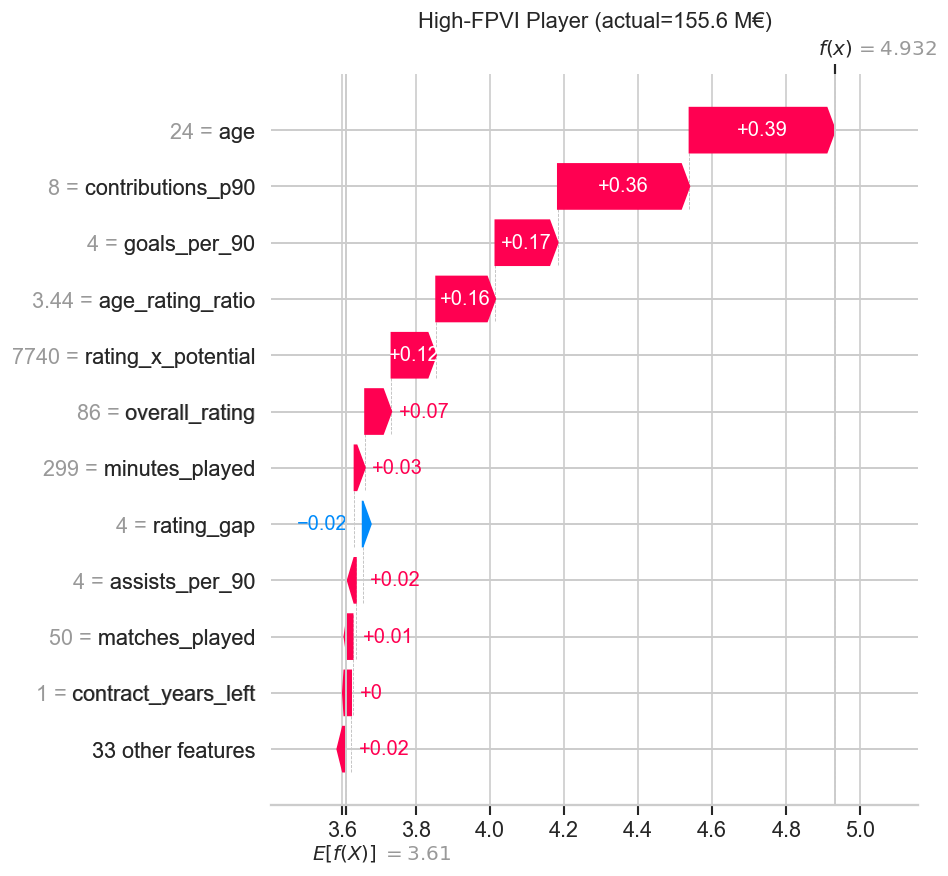

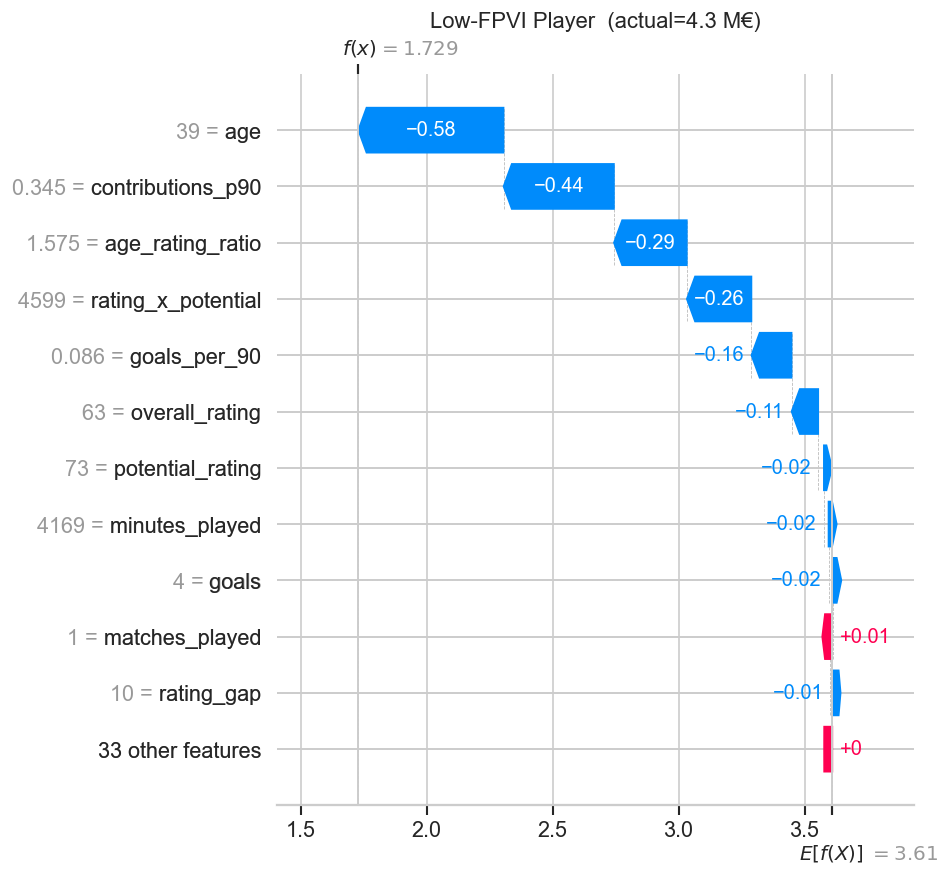

In [13]:
# Local waterfall: highest-FPVI and lowest-FPVI players in test set
y_fpvi_raw_te = d['y_fpvi_raw_te']
high_idx = int(y_fpvi_raw_te.values.argmax())
low_idx  = int(y_fpvi_raw_te.values.argmin())

for idx, label, fname in [
    (high_idx, f'High-FPVI Player (actual={y_fpvi_raw_te.iloc[high_idx]:.1f} M€)', 'shap_local_high'),
    (low_idx,  f'Low-FPVI Player  (actual={y_fpvi_raw_te.iloc[low_idx]:.1f} M€)',  'shap_local_low'),
]:
    shap.waterfall_plot(shap_values_reg[idx], max_display=12, show=False)
    plt.title(label)
    plt.tight_layout()
    plt.savefig(f'../outputs/{fname}.png', bbox_inches='tight')
    plt.show()

## 5. SHAP — Classifier Interpretability

In [14]:
try:
    explainer_cls = shap.TreeExplainer(best_cls_model)
    shap_values_cls = explainer_cls(X_test)
    print('TreeExplainer used for classifier — shape:', shap_values_cls.values.shape)
    has_cls_shap = True
except Exception as e:
    print(f'Could not compute SHAP for classifier: {e}')
    has_cls_shap = False

TreeExplainer used for classifier — shape: (420, 44, 3)


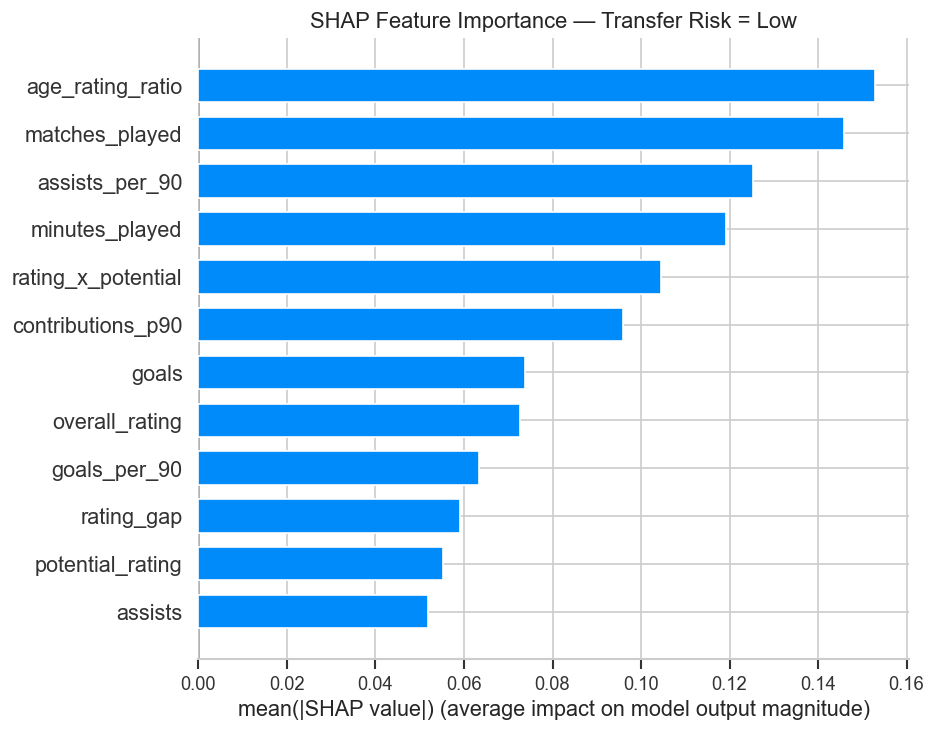

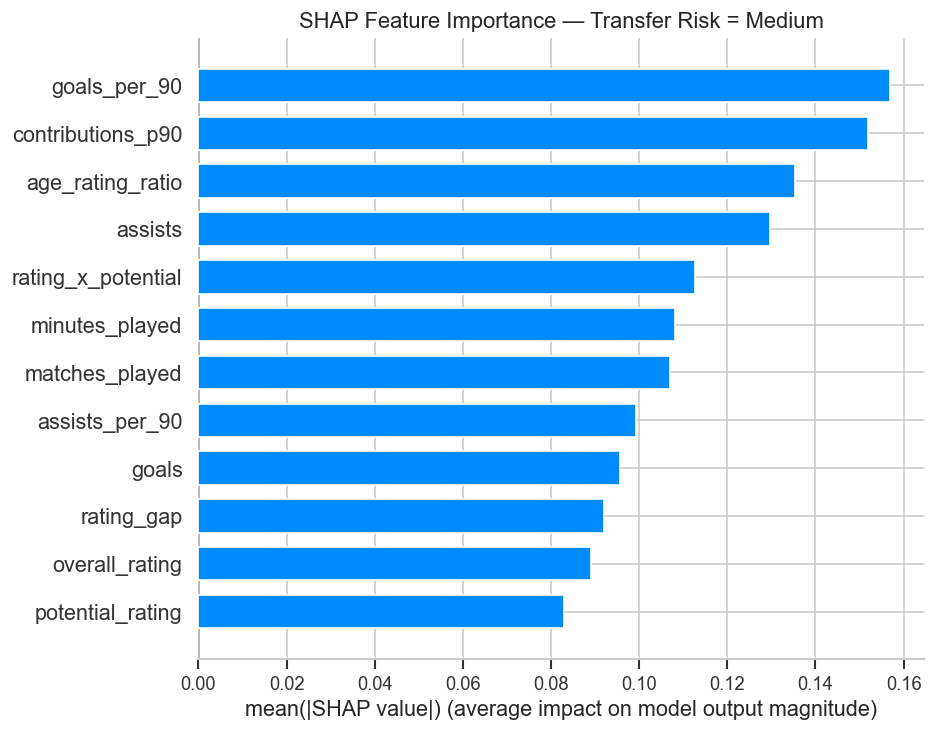

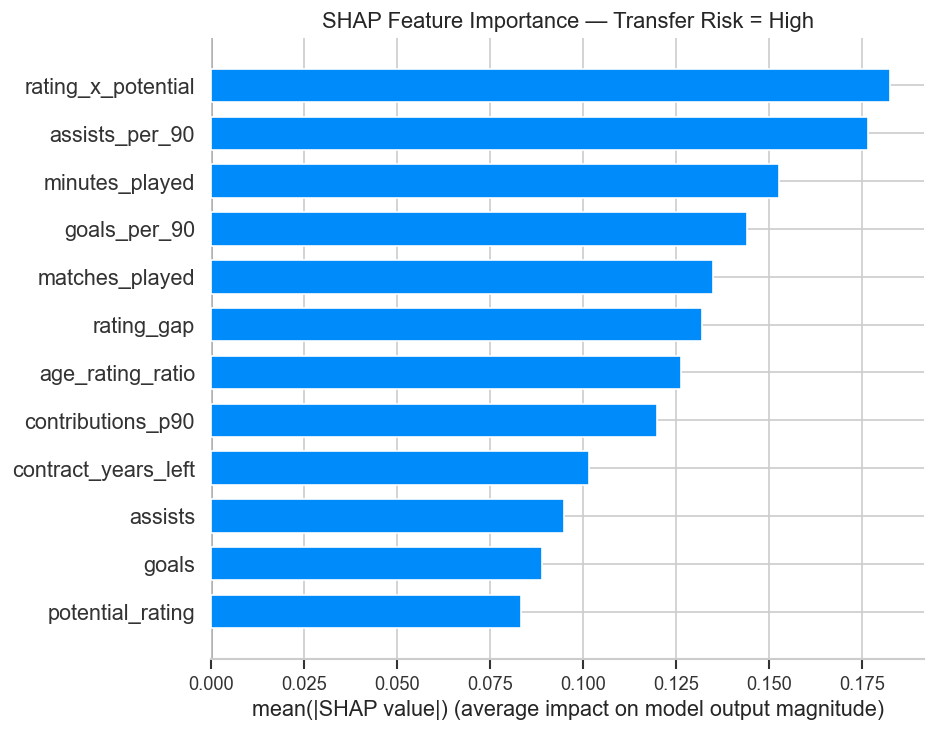

In [15]:
if has_cls_shap and shap_values_cls.values.ndim == 3:
    for cls_idx, cls_name in enumerate(CLASSES):
        sv = shap.Explanation(
            values=shap_values_cls.values[:, :, cls_idx],
            base_values=shap_values_cls.base_values[:, cls_idx],
            data=shap_values_cls.data,
            feature_names=feature_cols
        )
        shap.summary_plot(sv, X_test, plot_type='bar', max_display=12, show=False)
        plt.title(f'SHAP Feature Importance — Transfer Risk = {cls_name}')
        plt.tight_layout()
        plt.savefig(f'../outputs/shap_cls_{cls_name.lower()}.png', bbox_inches='tight')
        plt.show()
elif has_cls_shap:
    shap.summary_plot(shap_values_cls, X_test, plot_type='bar', max_display=12, show=False)
    plt.title('SHAP Feature Importance — Classifier')
    plt.tight_layout()
    plt.savefig('../outputs/shap_cls_all.png', bbox_inches='tight')
    plt.show()

## 6. SHAP Dependence Plots — Top Features

Top 2 SHAP features: ['age', 'contributions_p90']


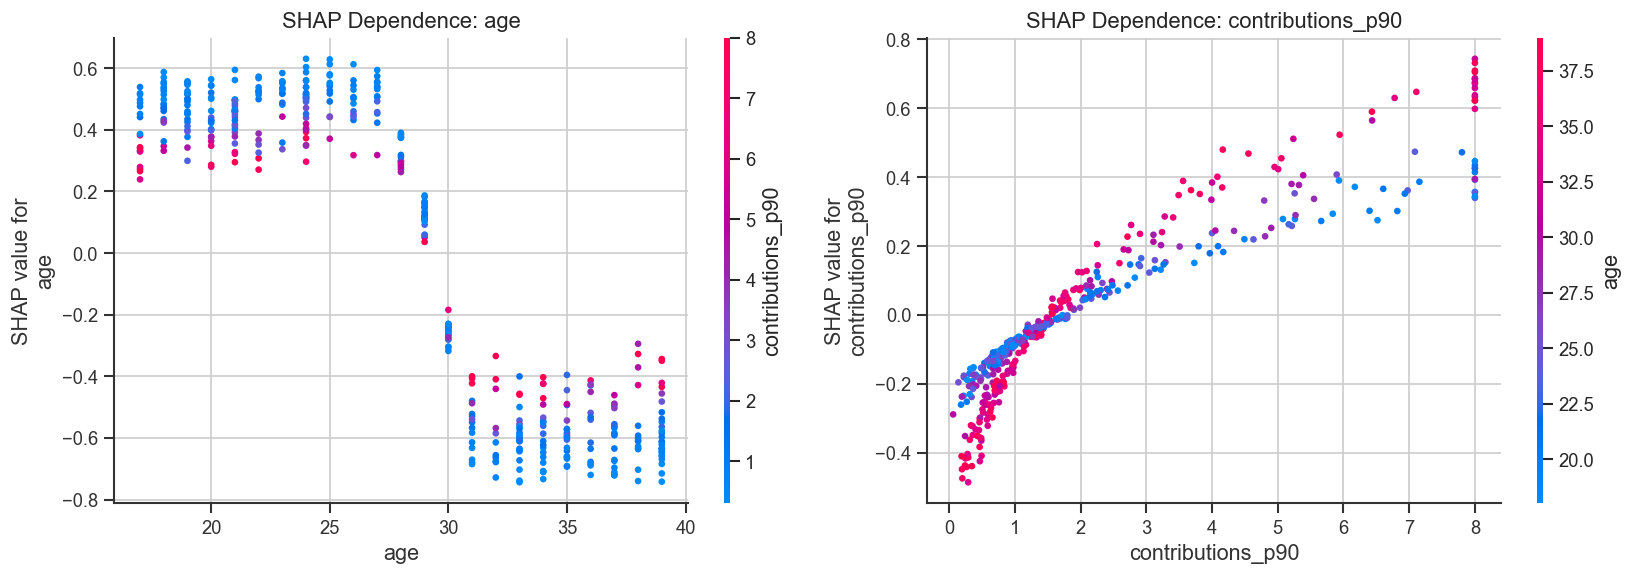

In [16]:
# Top-2 features by mean |SHAP| for regression
mean_shap = np.abs(shap_values_reg.values).mean(axis=0)
top2_idx  = np.argsort(mean_shap)[::-1][:2]
top2_feat = [feature_cols[i] for i in top2_idx]
print('Top 2 SHAP features:', top2_feat)

X_test_reset = X_test.reset_index(drop=True)
sv_values    = shap_values_reg.values   # (n_samples, n_features)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for ax, feat in zip(axes, top2_feat):
    shap.dependence_plot(feat, sv_values, X_test_reset,
                         ax=ax, show=False, interaction_index='auto')
    ax.set_title(f'SHAP Dependence: {feat}')
plt.tight_layout()
plt.savefig('../outputs/shap_dependence.png', bbox_inches='tight')
plt.show()

## 7. Save Best Classifier

In [17]:
with open('../outputs/best_classifier.pkl', 'wb') as f:
    pickle.dump({'model': best_cls_model, 'name': best_cls_name,
                 'feature_cols': feature_cols, 'classes': CLASSES}, f)
print(f'Saved best classifier: {best_cls_name}')

Saved best classifier: LightGBM


## 8. Summary

| Model | Task | Metric |
|---|---|---|
| Best Regressor | Market Value Prediction | RMSE / MAE / R² (see notebook 03) |
| Best Classifier | Transfer Risk Classification | Accuracy / Macro F1 / ROC-AUC (see above) |

**SHAP insights (regression):**
- `overall_rating` and `potential_rating` dominate predictions
- Age has a non-linear effect: mid-prime players (~25-28) receive the largest positive SHAP push
- `rating_gap` boosts value for young players with high upside
- Performance stats (goals/assists per 90) provide incremental signal beyond ratings

**SHAP insights (classifier):**
- `contract_years_left` is the dominant signal: fewer years → higher transfer risk
- High-rated young players at top clubs are also flagged as medium/high risk (attractive targets)
